In [1]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 106.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 19.9 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv

--2023-01-27 10:57:37--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 2607:f8b0:4023:c0d::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14174600 (14M) [application/octet-stream]
Saving to: ‘data/full_dataset/goemotions_1.csv’

goemotions_1.csv    100%[===================>]  13.52M  --.-KB/s    in 0.1s    

2023-01-27 10:57:38 (96.0 MB/s) - ‘data/full_dataset/goemotions_1.csv’ saved [14174600/14174600]

--2023-01-27 10:57:38--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 2607:f8b0:4023:c0d::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request se

In [52]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt


from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split


from pathlib import Path
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, 
                          PreTrainedModel, DistilBertModel, DistilBertForSequenceClassification, 
                          TrainingArguments, Trainer, BertForSequenceClassification)
from transformers.modeling_outputs import SequenceClassifierOutput

import torch


In [4]:
df_1 = pd.read_csv('/content/data/full_dataset/goemotions_1.csv')
df_2 = pd.read_csv('/content/data/full_dataset/goemotions_2.csv')
df_3 = pd.read_csv('/content/data/full_dataset/goemotions_3.csv')

In [5]:
df_1.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1


In [6]:
df_combined = pd.concat([df_1, df_2, df_3], axis=0)

In [7]:
df_combined.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1


In [8]:
for row in df_combined:
  print(row)

text
id
author
subreddit
link_id
parent_id
created_utc
rater_id
example_very_unclear
admiration
amusement
anger
annoyance
approval
caring
confusion
curiosity
desire
disappointment
disapproval
disgust
embarrassment
excitement
fear
gratitude
grief
joy
love
nervousness
optimism
pride
realization
relief
remorse
sadness
surprise
neutral


In [9]:
df = df_combined[['text', 'anger', 'disgust', 'fear', 'joy', 'surprise', 'sadness', 'neutral']].copy()


In [10]:
lables = ['anger', 'disgust', 'fear', 'happy', 'surprise', 'sadness', 'neutral']

In [11]:
df_combined

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71220,Everyone likes [NAME].,ee6pagw,Senshado,heroesofthestorm,t3_agjf24,t3_agjf24,1.547634e+09,16,False,0,...,1,0,0,0,0,0,0,0,0,0
71221,Well when you’ve imported about a gazillion of...,ef28nod,5inchloser,nottheonion,t3_ak26t3,t3_ak26t3,1.548553e+09,15,False,0,...,0,0,0,0,0,0,0,0,0,0
71222,That looks amazing,ee8hse1,springt1me,shittyfoodporn,t3_agrnqb,t3_agrnqb,1.547684e+09,70,False,1,...,0,0,0,0,0,0,0,0,0,0
71223,The FDA has plenty to criticize. But like here...,edrhoxh,enamedata,medicine,t3_aejqzd,t1_edrgdtx,1.547169e+09,4,False,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
lables

['anger', 'disgust', 'fear', 'happy', 'surprise', 'sadness', 'neutral']

In [13]:
df = df.rename(columns={'joy': 'happy'})
df = df.rename(columns={'text': 'sentence'})

In [14]:
df["labels"] = df[lables].values.tolist()
df.head()

,sentence,anger,disgust,fear,happy,surprise,sadness,neutral,labels
0,That game hurt.,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 1, 0]"
1,>sexuality shouldn’t be a grouping category I...,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0]"
2,"You do right, if you don't care then fuck 'em!",0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 1]"
3,Man I love reddit.,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0]"
4,"[NAME] was nowhere near them, he was by the Fa...",0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 1]"


In [15]:
df.shape

(211225, 9)

In [16]:
df = df[(df[['anger', 'disgust', 'fear', 'happy', 'surprise', 'sadness', 'neutral']] != 0).any(axis=1)]
df

,sentence,anger,disgust,fear,happy,surprise,sadness,neutral,labels
0,That game hurt.,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 1, 0]"
2,"You do right, if you don't care then fuck 'em!",0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 1]"
4,"[NAME] was nowhere near them, he was by the Fa...",0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 1]"
10,"I have, and now that you mention it, I think t...",0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 1]"
12,BUT IT'S HER TURN! /s,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 1]"
...,...,...,...,...,...,...,...,...,...
71212,What a great photo and you two look so happy. 😍,0,0,0,1,0,0,0,"[0, 0, 0, 1, 0, 0, 0]"
71213,"Wow, she headlines two shows now",0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 1]"
71215,Youtube is my Wikipedia. Videos about any inte...,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 1]"
71219,"Well, I'm glad you're out of all that now. How...",0,0,0,1,0,0,0,"[0, 0, 0, 1, 0, 0, 0]"


In [17]:
df.shape

(90698, 9)

In [18]:
df.to_csv("updated_data.csv", index=False)

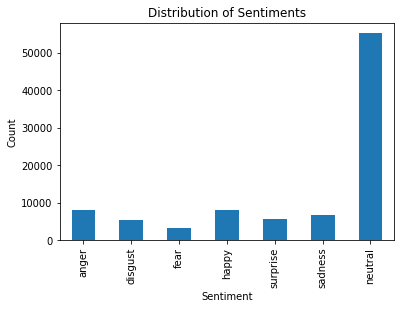

In [19]:
data = df[['anger', 'disgust', 'fear', 'happy', 'surprise', 'sadness', 'neutral']]

# create a histogram
data.sum().plot.bar()
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')

# display the histogram
plt.show()

In [20]:
df['neutral'].sum()

55298

In [21]:
# compute the number of neutral rows you want to keep
num_neutral_to_keep = df['neutral'].sum() - (df['sadness'].sum() + df['happy'].sum()+ df['disgust'].sum()+ df['anger'].sum()+ df['fear'].sum()+ df['surprise'].sum())
print(int(num_neutral_to_keep))

df_temp = pd.concat([df[df['sadness']==1],df[df['happy']==1],df[df['disgust']==1],df[df['anger']==1],df[df['fear']==1],df[df['surprise']==1]])
# filter the DataFrame to only keep the neutral rows you want to keep
ds = df[df['neutral'] == 1].sample(int(num_neutral_to_keep))

# append all the rows to the filtered DataFrame
df = pd.concat([ds,df_temp[df_temp['sadness']==1],df_temp[df_temp['happy']==1],df_temp[df_temp['disgust']==1],df_temp[df_temp['anger']==1],df_temp[df_temp['fear']==1],df_temp[df_temp['surprise']==1]])

18461


In [22]:
df

,sentence,anger,disgust,fear,happy,surprise,sadness,neutral,labels
52899,"I just call em like I see em, [NAME]",0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 1]"
52576,"[NAME] was mad, I could see it in his eyes",0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 1]"
34462,Who are you and how did you know I was watchin...,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 1]"
66715,They added colour to Belfast!,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 1]"
26358,What a biotch,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 1]"
...,...,...,...,...,...,...,...,...,...
71083,> you're probably a little bit of a closeted n...,0,0,0,0,1,0,0,"[0, 0, 0, 0, 1, 0, 0]"
71105,> you're probably a little bit of a closeted n...,0,0,0,0,1,0,0,"[0, 0, 0, 0, 1, 0, 0]"
71116,OH YEAH!!,0,0,0,0,1,0,0,"[0, 0, 0, 0, 1, 0, 0]"
71151,Yeh? It just changed on me last night after I ...,0,0,0,0,1,0,0,"[0, 0, 0, 0, 1, 0, 0]"


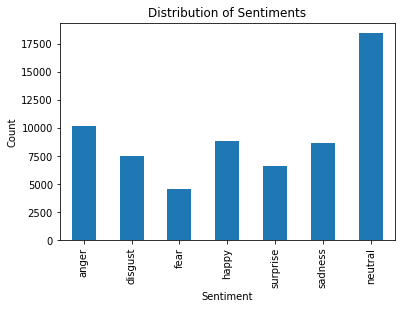

In [23]:
data = df[['anger', 'disgust', 'fear', 'happy', 'surprise', 'sadness', 'neutral']]

# create a histogram
data.sum().plot.bar()
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')

# display the histogram
plt.show()

In [24]:
df.shape

(58302, 9)

In [25]:
from sklearn.utils import shuffle
df = shuffle(df)

In [26]:
df

,sentence,anger,disgust,fear,happy,surprise,sadness,neutral,labels
26064,[NAME] has so many people shook.,0,1,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0]"
67453,I've actually been teaching myself R lately fo...,0,0,0,1,0,0,0,"[0, 0, 0, 1, 0, 0, 0]"
1042,This sounds serious. I don't think I have the ...,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 1]"
49581,This is a terrible idea,0,0,1,0,1,0,0,"[0, 0, 1, 0, 1, 0, 0]"
10227,"""That's impossible."" ""It's necessary."" If they...",0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 1]"
...,...,...,...,...,...,...,...,...,...
43286,"[NAME] lmaooo this made me laugh, thank you 😂",0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 1]"
20477,Nothing. Fuck the environment so people can th...,1,1,1,0,0,0,0,"[1, 1, 1, 0, 0, 0, 0]"
33464,"He ""dies"" shortly after the inn, from a wound ...",0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 1]"
69729,"Oh, the ""Thomas the nuclear bomb""? That scarre...",0,0,1,0,0,1,0,"[0, 0, 1, 0, 0, 1, 0]"


In [27]:
# remove rows that belong to more than one sentiment
df = df.query('(anger == 1) | (disgust == 1) | (fear == 1) | (happy == 1) | (surprise == 1) | (sadness == 1) | (neutral == 1)')


In [28]:
df

,sentence,anger,disgust,fear,happy,surprise,sadness,neutral,labels
26064,[NAME] has so many people shook.,0,1,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0]"
67453,I've actually been teaching myself R lately fo...,0,0,0,1,0,0,0,"[0, 0, 0, 1, 0, 0, 0]"
1042,This sounds serious. I don't think I have the ...,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 1]"
49581,This is a terrible idea,0,0,1,0,1,0,0,"[0, 0, 1, 0, 1, 0, 0]"
10227,"""That's impossible."" ""It's necessary."" If they...",0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 1]"
...,...,...,...,...,...,...,...,...,...
43286,"[NAME] lmaooo this made me laugh, thank you 😂",0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 1]"
20477,Nothing. Fuck the environment so people can th...,1,1,1,0,0,0,0,"[1, 1, 1, 0, 0, 0, 0]"
33464,"He ""dies"" shortly after the inn, from a wound ...",0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 1]"
69729,"Oh, the ""Thomas the nuclear bomb""? That scarre...",0,0,1,0,0,1,0,"[0, 0, 1, 0, 0, 1, 0]"


In [29]:
df.to_csv("updated_data.csv", index=False)

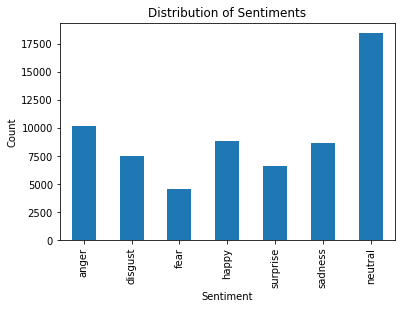

In [30]:
data = df[['anger', 'disgust', 'fear', 'happy', 'surprise', 'sadness', 'neutral']]

# create a histogram
data.sum().plot.bar()
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')

# display the histogram
plt.show()

In [31]:
!head updated_data.csv

sentence,anger,disgust,fear,happy,surprise,sadness,neutral,labels
[NAME] has so many people shook.,0,1,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0]"
"I've actually been teaching myself R lately for this exact purpose, I'm super excited to check out your book when you're done with it. ",0,0,0,1,0,0,0,"[0, 0, 0, 1, 0, 0, 0]"
This sounds serious. I don't think I have the ability to help ya but you definitely need to talk to someone.,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 1]"
This is a terrible idea,0,0,1,0,1,0,0,"[0, 0, 1, 0, 1, 0, 0]"
"""That's impossible."" ""It's necessary."" If they were aiming to make a [NAME] a steely-eyed missile man, they succeeded. ",0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 1]"
Well stop drinking bovine growth hormone then.,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 1]"
Mammy ah fargat me passpart ah have te go down te rowckets and get a canny coke for wan fofty hi,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 1]"
Fruit is byfar the worst of all flavors,0,1,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0]"
"That might be i

In [32]:

# create train / test splits
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]

(df_train.shape, df_test.shape)

((46542, 9), (11760, 9))

In [33]:
checkpoint = 'bert-base-cased'

In [34]:
from transformers import AutoTokenizer

In [35]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [36]:

train_encodings = tokenizer(df["sentence"].values.tolist(), truncation=True)
test_encodings = tokenizer(df["sentence"].values.tolist(), truncation=True)

In [37]:
train_labels = df_train["labels"].values.tolist()
test_labels = df_test["labels"].values.tolist()

In [38]:
class GoEmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [39]:

train_dataset = GoEmotionDataset(train_encodings, train_labels)
test_dataset = GoEmotionDataset(test_encodings, test_labels)

In [40]:

train_dataset[0]

{'input_ids': tensor([  101,   164,   151, 10964,  2036,   166,  1144,  1177,  1242,  1234,
          2291,   119,   102]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'labels': tensor([0, 1, 0, 0, 0, 0, 0])}

In [41]:
# sanity check
tokenizer.decode(train_dataset[0]["input_ids"])

'[CLS] [ NAME ] has so many people shook. [SEP]'

In [53]:

class BertForMultilabelSequenceClassification(BertForSequenceClassification):
    def __init__(self, config):
      super().__init__(config)

    def forward(self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict)

        hidden_state = outputs[0]
        pooled_output = hidden_state[:, 0]  
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = torch.nn.BCEWithLogitsLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), 
                            labels.float().view(-1, self.num_labels))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions)
     

In [54]:
num_labels=7
model = BertForMultilabelSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels).to('cuda')

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/5532cc56f74641d4bb33641f5c76a55d11f846e0/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transfo

In [55]:
model.config.id2label = {
    "0": "anger",
    "1": "disgust",
    "2": "fear",
    "3": "happy",
    "4": "surprise",
    "5": "sadness",
    "6": "neutral",
},
model.config.label2id ={
    "anger": 0,
    "disgust": 1,
    "fear": 2,
    "happy": 3,
    "surprise": 4,
    "sadness": 5,
    "neutral": 6,

}
model.config

BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": [
    {
      "0": "anger",
      "1": "disgust",
      "2": "fear",
      "3": "happy",
      "4": "surprise",
      "5": "sadness",
      "6": "neutral"
    }
  ],
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 0,
    "disgust": 1,
    "fear": 2,
    "happy": 3,
    "neutral": 6,
    "sadness": 5,
    "surprise": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

In [ ]:
!pip install torchinfo
from torchinfo import summary

In [146]:
summary(model)

Layer (type:depth-idx)                                  Param #
BertForMultilabelSequenceClassification                 --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           5,383
Total params: 10

In [46]:

def accuracy_thresh(y_pred, y_true, thresh=0.5, sigmoid=True): 
    y_pred = torch.from_numpy(y_pred)
    y_true = torch.from_numpy(y_true)
    if sigmoid: 
      y_pred = y_pred.sigmoid()
    return ((y_pred>thresh)==y_true.bool()).float().mean().item()

In [47]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    return {'accuracy_thresh': accuracy_thresh(predictions, labels)}


In [48]:
batch_size = 32
# configure logging so we see training loss
logging_steps = len(train_dataset) // batch_size

args = TrainingArguments(
    output_dir="emotion",
    evaluation_strategy = "epoch",
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=logging_steps
)

In [56]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer)

In [57]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 11760
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForMultilabelSequenceClassification.forward` and have been ignored: token_type_ids. If token_type_ids are not expected by `BertForMultilabelSequenceClassification.forward`,  you can safely ignore this message.


{'eval_loss': 0.6705002784729004,
 'eval_accuracy_thresh': 0.6622205972671509,
 'eval_runtime': 10.6174,
 'eval_samples_per_second': 1107.618,
 'eval_steps_per_second': 34.66}

In [58]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 46542
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 14545
  Number of trainable parameters = 108315655
The following columns in the training set don't have a corresponding argument in `BertForMultilabelSequenceClassification.forward` and have been ignored: token_type_ids. If token_type_ids are not expected by `BertForMultilabelSequenceClassification.forward`,  you can safely ignore this message.


Epoch,Training Loss,Validation Loss,Accuracy Thresh
1,0.422500,0.422336,0.841217
2,0.420100,0.421620,0.841217
3,0.413100,0.431024,0.839529
4,0.381700,0.464232,0.826397
5,0.360400,0.493175,0.813132


***** Running Evaluation *****
  Num examples = 11760
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForMultilabelSequenceClassification.forward` and have been ignored: token_type_ids. If token_type_ids are not expected by `BertForMultilabelSequenceClassification.forward`,  you can safely ignore this message.


Saving model checkpoint to emotion/checkpoint-2909
Configuration saved in emotion/checkpoint-2909/config.json
Model weights saved in emotion/checkpoint-2909/pytorch_model.bin
tokenizer config file saved in emotion/checkpoint-2909/tokenizer_config.json
Special tokens file saved in emotion/checkpoint-2909/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 11760
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForMultilabelSequenceClassification.forward` and have been ignored: token_type_ids. If token_type_ids are not expected by `BertForMultilabelSequenceClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to emotion/checkpoint-5818
Configuration saved in emotion/checkpoint-5818/config.json
Model weights saved in emotion/checkpoint-5818/pytorch_model.bin
tokenizer config file saved in emotion/checkpoint-5818/tokenizer_config.json
Special tokens file saved in emotion/checkpoint-5

TrainOutput(global_step=14545, training_loss=0.4000318944474683, metrics={'train_runtime': 916.2316, 'train_samples_per_second': 253.986, 'train_steps_per_second': 15.875, 'total_flos': 4510645420398000.0, 'train_loss': 0.4000318944474683, 'epoch': 5.0})

In [155]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 11760
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForMultilabelSequenceClassification.forward` and have been ignored: token_type_ids. If token_type_ids are not expected by `BertForMultilabelSequenceClassification.forward`,  you can safely ignore this message.


{'eval_loss': 0.49317485094070435,
 'eval_accuracy_thresh': 0.8131316900253296,
 'eval_runtime': 8.6241,
 'eval_samples_per_second': 1363.626,
 'eval_steps_per_second': 42.671,
 'epoch': 5.0}

In [ ]:
test_dataset.labels

In [100]:
trainer.save_model('my_saved_model')

Saving model checkpoint to my_saved_model
Configuration saved in my_saved_model/config.json
Model weights saved in my_saved_model/pytorch_model.bin
tokenizer config file saved in my_saved_model/tokenizer_config.json
Special tokens file saved in my_saved_model/special_tokens_map.json


In [103]:
!cat emotion/checkpoint-2909/config.json

{
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMultilabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": 
    {
      "0": "anger",
      "1": "disgust",
      "2": "fear",
      "3": "happy",
      "4": "surprise",
      "5": "sadness",
      "6": "neutral"
    }
  ,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 0,
    "disgust": 1,
    "fear": 2,
    "happy": 3,
    "neutral": 6,
    "sadness": 5,
    "surprise": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.26.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 2899

In [144]:
#modify config.json first
newmodel = pipeline('text-classification', model='emotion/checkpoint-14545', device=0)

loading configuration file emotion/checkpoint-14545/config.json
Model config BertConfig {
  "_name_or_path": "emotion/checkpoint-14545",
  "architectures": [
    "BertForMultilabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "anger",
    "1": "disgust",
    "2": "fear",
    "3": "happy",
    "4": "surprise",
    "5": "sadness",
    "6": "neutral"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 0,
    "disgust": 1,
    "fear": 2,
    "happy": 3,
    "neutral": 6,
    "sadness": 5,
    "surprise": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4

In [108]:
newmodel('This movie is great')

[{'label': 'happy', 'score': 0.2232130467891693}]

In [109]:
newmodel('This movie sucks')

[{'label': 'happy', 'score': 0.22650203108787537}]

In [ ]:
test_pred = newmodel()

In [112]:
from datasets import load_dataset
raw_dataset = load_dataset('csv', data_files='updated_data.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-9868d11cb1f4a642/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [145]:
newmodel('Those who had tried to remain neutral now found themselves required to take sides.')

[{'label': 'happy', 'score': 0.20980970561504364}]

In [ ]:
my_model = model.load_state_dict(torch.load('/model')) 

In [160]:
my_model

<All keys matched successfully>

In [161]:
review_text = "I love completing my todos! Best app ever!!!"

In [163]:
MAX_LEN = 160
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [164]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [167]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {lables[prediction]}')

TypeError: ignored

In [169]:
input_ids

tensor([[  101,   146,  1567,  7332,  1139,  1106, 12847,   106,  1798, 12647,
          1518,   106,   106,   106,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  